* 참조 : https://www.kaggle.com/allunia/breast-cancer

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

In [ ]:
run_training = False
retrain = False
find_learning_rate = False

In [23]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/total_project/breast/breast

/content/drive/MyDrive/Colab Notebooks/total_project/breast/breast


In [ ]:
!unzip archive.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/

In [ ]:
!pwd

/content


In [ ]:
files = listdir("/content/drive/MyDrive/Colab Notebooks/dataset")
print(len(files))

81


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seungeunsong","key":"d6129a2a69ee2d24c113da655240fa30"}'}

In [ ]:
!mkdir ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

cp: 'kaggle.json' and '/root/.kaggle/kaggle.json' are the same file


In [ ]:
%cd ~/.kaggle

/root/.kaggle


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/total_project/breast

/content/drive/MyDrive/Colab Notebooks/total_project/breast


In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:35<00:00, 30.5MB/s]
100% 3.10G/3.10G [00:39<00:00, 84.7MB/s]


In [24]:
%cd /content/drive/MyDrive/Colab Notebooks/total_project/breast/breast-histopathology-images

/content/drive/MyDrive/Colab Notebooks/total_project/breast/breast-histopathology-images


In [26]:
!unzip breast-histopathology-images.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/

In [28]:
files = listdir("/content/drive/MyDrive/Colab Notebooks/total_project/breast/breast-histopathology-images")
len(files)

281

In [29]:
base_path = "/content/drive/MyDrive/Colab Notebooks/total_project/breast/breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

In [33]:
total_images = 0

for n in range(len(folder)):
  patient_id = folder[n]
  for c in [0, 1]:
    patient_path = base_path + patient_id
    class_path = patient_path + "/" + str(c) + "/"
    subfiles = listdir(class_path)
    total_images += len(subfiles)

In [34]:
total_images

277524

In [35]:
data = pd.DataFrame(index=np.arange(0, total_images), columns =['patient_id','path','target'])

k = 0

for n in range(len(folder)):
  patient_id = folder[n]
  patient_path = base_path + patient_id
  for c in [0,1]:
    class_path = patient_path + "/" + str(c) + "/"
    subfiles = listdir(class_path)
    for m in range(len(subfiles)):
      image_path = subfiles[m]
      data.iloc[k]["path"]= class_path + image_path
      data.iloc[k]["target"] = c
      data.iloc[k]["patient_id"] = patient_id
      k += 1

data.head()

patient_id                                               path target
0      10253  /content/drive/MyDrive/Colab Notebooks/total_p...      0
1      10253  /content/drive/MyDrive/Colab Notebooks/total_p...      0
2      10253  /content/drive/MyDrive/Colab Notebooks/total_p...      0
3      10253  /content/drive/MyDrive/Colab Notebooks/total_p...      0
4      10253  /content/drive/MyDrive/Colab Notebooks/total_p...      0

In [42]:
type(data)

pandas.core.frame.DataFrame

In [36]:
data.path[0]

'/content/drive/MyDrive/Colab Notebooks/total_project/breast/breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1001_class0.png'

In [37]:
data.shape

(277524, 3)

In [44]:
data.groupby(["patient_id"]).target.value_counts()

patient_id  target
10253       0          479
            1           70
10254       0          772
            1           76
10255       0          181
                      ... 
9381        1          128
9382        0         1306
            1          346
9383        0          494
            1           70
Name: target, Length: 558, dtype: int64

In [45]:
data.groupby(["patient_id"]).target.size()

patient_id
10253     549
10254     848
10255     272
10256     468
10257     635
         ... 
9346     1361
9347      410
9381     1326
9382     1652
9383      564
Name: target, Length: 279, dtype: int64

In [46]:
data.groupby(["patient_id"]).size()

patient_id
10253     549
10254     848
10255     272
10256     468
10257     635
         ... 
9346     1361
9347      410
9381     1326
9382     1652
9383      564
Length: 279, dtype: int64

* **unstack** - 데이터 재구조화 : stack이 (위에서 아래로 길게, 높게) 쌓는 것이면, unstack은 쌓은 것을 옆으로 늘어놓는것(왼쪽에서 오른쪽으로 넓게)

    * 출처: https://rfriend.tistory.com/276 

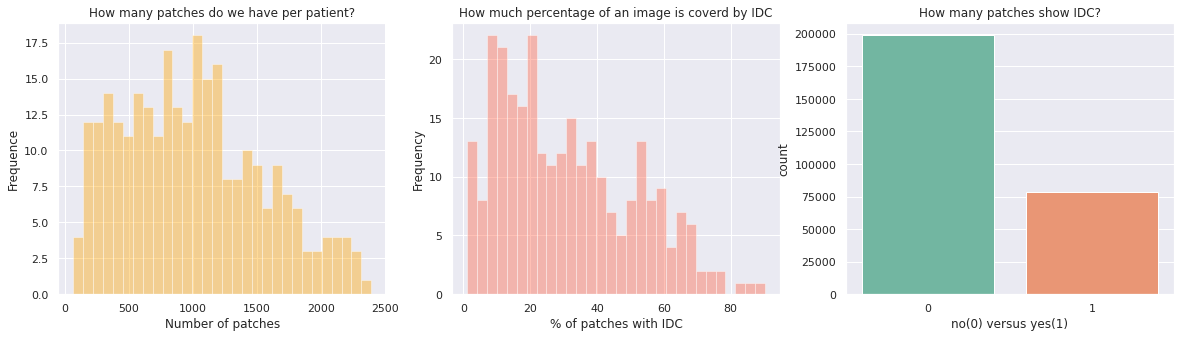

In [49]:
cancer_perc = data.groupby(["patient_id"]).target.value_counts()/data.groupby(["patient_id"]).target.size()
cancer_perc = cancer_perc.unstack() 

fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.distplot(data.groupby(["patient_id"]).size(), ax=ax[0], color = "Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequence");
ax[0].set_title("How many patches do we have per patient?");

sns.distplot(cancer_perc.loc[:,1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is coverd by IDC")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");

sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

In [50]:
cancer_perc.head()

target             0         1
patient_id                    
10253       0.872495  0.127505
10254       0.910377  0.089623
10255       0.665441  0.334559
10256       0.750000  0.250000
10257       0.672441  0.327559

In [53]:
data.target = data.target.astype(np.int)

In [57]:
data.target.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [63]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

In [61]:
pos_selection

array([179081, 259404,  44030,  96944,  34567, 209544,   7795, 124557,
       124973,  33089,  92927, 248059, 231457, 222460, 108083,  90399,
       183686,  29987, 135052, 133572,  19758, 169439, 145180, 247834,
        48395, 254947, 270878,  82591,  66440, 247673, 273036, 170985,
        82206, 141307, 206646,  68728,  36424, 186039, 126227,  16698,
        77639, 237621, 178817, 209417, 109092, 255071, 146951, 254635,
       211129, 251305])

In [65]:
data[data.target==1].index.values

array([   479,    480,    481, ..., 277521, 277522, 277523])

In [68]:
data[data.target==1].index

Int64Index([   479,    480,    481,    482,    483,    484,    485,    486,
               487,    488,
            ...
            277514, 277515, 277516, 277517, 277518, 277519, 277520, 277521,
            277522, 277523],
           dtype='int64', length=78786)

In [67]:
len(pos_selection) # size=50설정

50

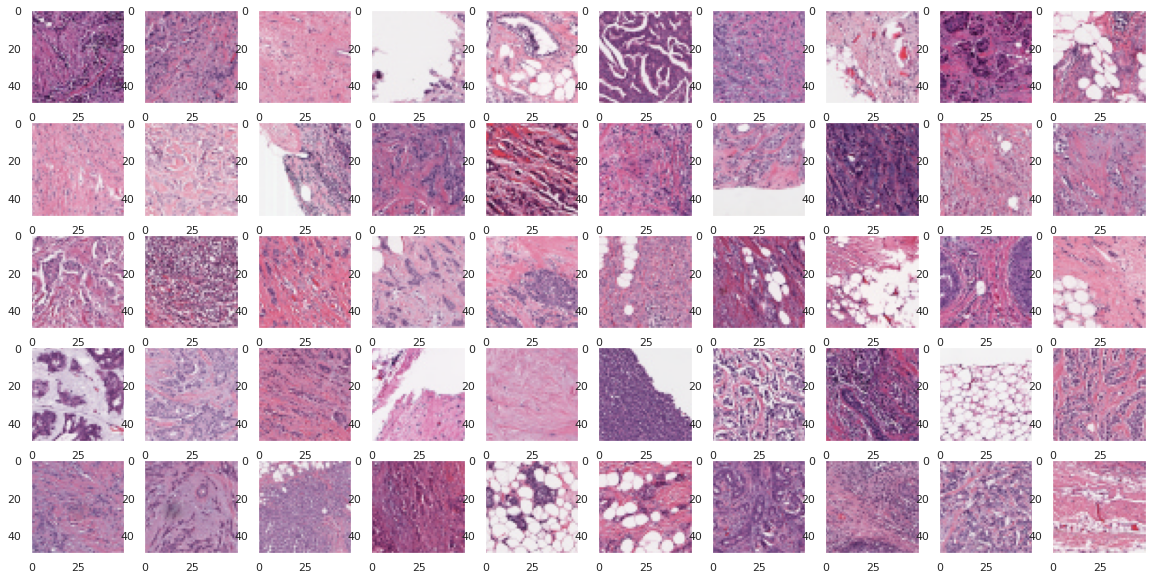

In [70]:
fig, ax = plt.subplots(5,10, figsize=(20,10))

for n in range(5):
  for m in range(10):
    idx = pos_selection[m+10*n]
    image = imread(data.loc[idx, "path"])
    ax[n,m].imshow(image)
    ax[n,m].grid(False)

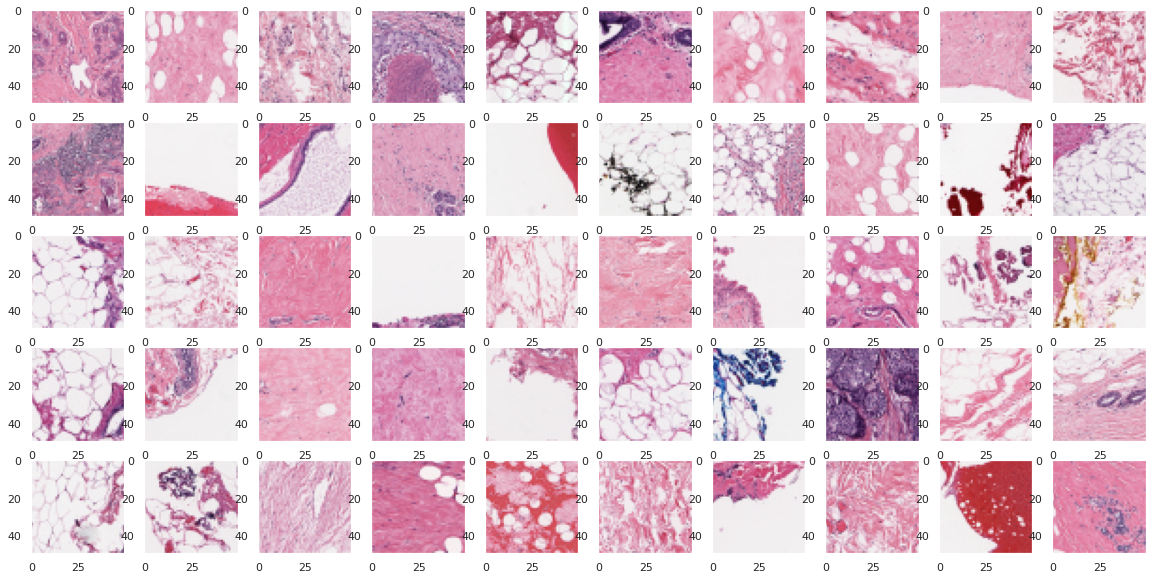

In [71]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [77]:
data.path[0]

'/content/drive/MyDrive/Colab Notebooks/total_project/breast/breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1001_class0.png'

In [82]:
def extract_coords(df):
  coord = df.path.str.rsplit("_", n=4, expand=True)
  print("rsplit:", coodr)
  coord = coord.drop([0,1,4], axis=1)
  print("drop:",coord)
  coord = coord.rename({2: "x", 3: "y"}, axis=1)
  print("rename:",coord)
  coord.loc[:,"x"] = coord.loc[:,"x"].str.replace("x","",case=False).astype(np.int)
  coord.loc[:,"y"] = coord.loc[:,"y"].str.replace("y","",case=False).astype(np.int)
  df.loc[:,"x"] = coord.x.values
  df.loc[:,"y"] = coord.y.values
  return df

def get_cancer_dataframe(patinet_id, cancer_id):
  path = base_path + patient_id + "/" + cancer_id
  files = listdir(path)
  dataframe = pd.DataFrame(files, columns=['filename'])
  path_names = path+"/"+dataframe.filename.values
  print("dataframe:",dataframe)
  dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
  print("rsplit:", dataframe)
  dataframe.loc[:,"target"] = np.int(cancer_id)
  dataframe.loc[:,"path"]  = path_names
  dataframe = dataframe.drop([0,1,4],axis=1)
  print("drop:",dataframe)
  dataframe = dataframe.rename({2:"x", 3:"y"}, axis=1)
  print("rename:",dataframe)
  dataframe.loc[:,"x"] = dataframe.loc[:,"x"].str.replace("x","",case=False).astype(np.int)
  dataframe.loc[:,"y"] = dataframe.loc[:,"y"].str.replace("y","",case=False).astype(np.int)
  return dataframe

def get_patient_dataframe(patient_id):
  df_0 = get_cancer_dataframe(patient_id, "0")
  df_1 = get_cancer_dataframe(patient_id, "1")
  patient_df = df_0.append(df_1)
  return patient_df

In [85]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()
example_df.x.values

dataframe:                               filename
0    10273_idx5_x1001_y1901_class0.png
1    10273_idx5_x1001_y1951_class0.png
2    10273_idx5_x1001_y2001_class0.png
3    10273_idx5_x1001_y2051_class0.png
4    10273_idx5_x1001_y2101_class0.png
..                                 ...
806    10273_idx5_x951_y251_class0.png
807    10273_idx5_x951_y301_class0.png
808    10273_idx5_x951_y351_class0.png
809    10273_idx5_x951_y401_class0.png
810    10273_idx5_x951_y451_class0.png

[811 rows x 1 columns]
rsplit:          0     1      2      3           4
0    10273  idx5  x1001  y1901  class0.png
1    10273  idx5  x1001  y1951  class0.png
2    10273  idx5  x1001  y2001  class0.png
3    10273  idx5  x1001  y2051  class0.png
4    10273  idx5  x1001  y2101  class0.png
..     ...   ...    ...    ...         ...
806  10273  idx5   x951   y251  class0.png
807  10273  idx5   x951   y301  class0.png
808  10273  idx5   x951   y351  class0.png
809  10273  idx5   x951   y401  class0.png
810  10273  idx5

array([1001, 1001, 1001, ...,  951,  951,  951])

dataframe:                               filename
0    10253_idx5_x1001_y1001_class0.png
1    10253_idx5_x1001_y1051_class0.png
2    10253_idx5_x1001_y1101_class0.png
3    10253_idx5_x1001_y1151_class0.png
4    10253_idx5_x1001_y1201_class0.png
..                                 ...
474    10253_idx5_x951_y651_class0.png
475    10253_idx5_x951_y701_class0.png
476    10253_idx5_x951_y751_class0.png
477    10253_idx5_x951_y801_class0.png
478    10253_idx5_x951_y851_class0.png

[479 rows x 1 columns]
rsplit:          0     1      2      3           4
0    10253  idx5  x1001  y1001  class0.png
1    10253  idx5  x1001  y1051  class0.png
2    10253  idx5  x1001  y1101  class0.png
3    10253  idx5  x1001  y1151  class0.png
4    10253  idx5  x1001  y1201  class0.png
..     ...   ...    ...    ...         ...
474  10253  idx5   x951   y651  class0.png
475  10253  idx5   x951   y701  class0.png
476  10253  idx5   x951   y751  class0.png
477  10253  idx5   x951   y801  class0.png
478  10253  idx5

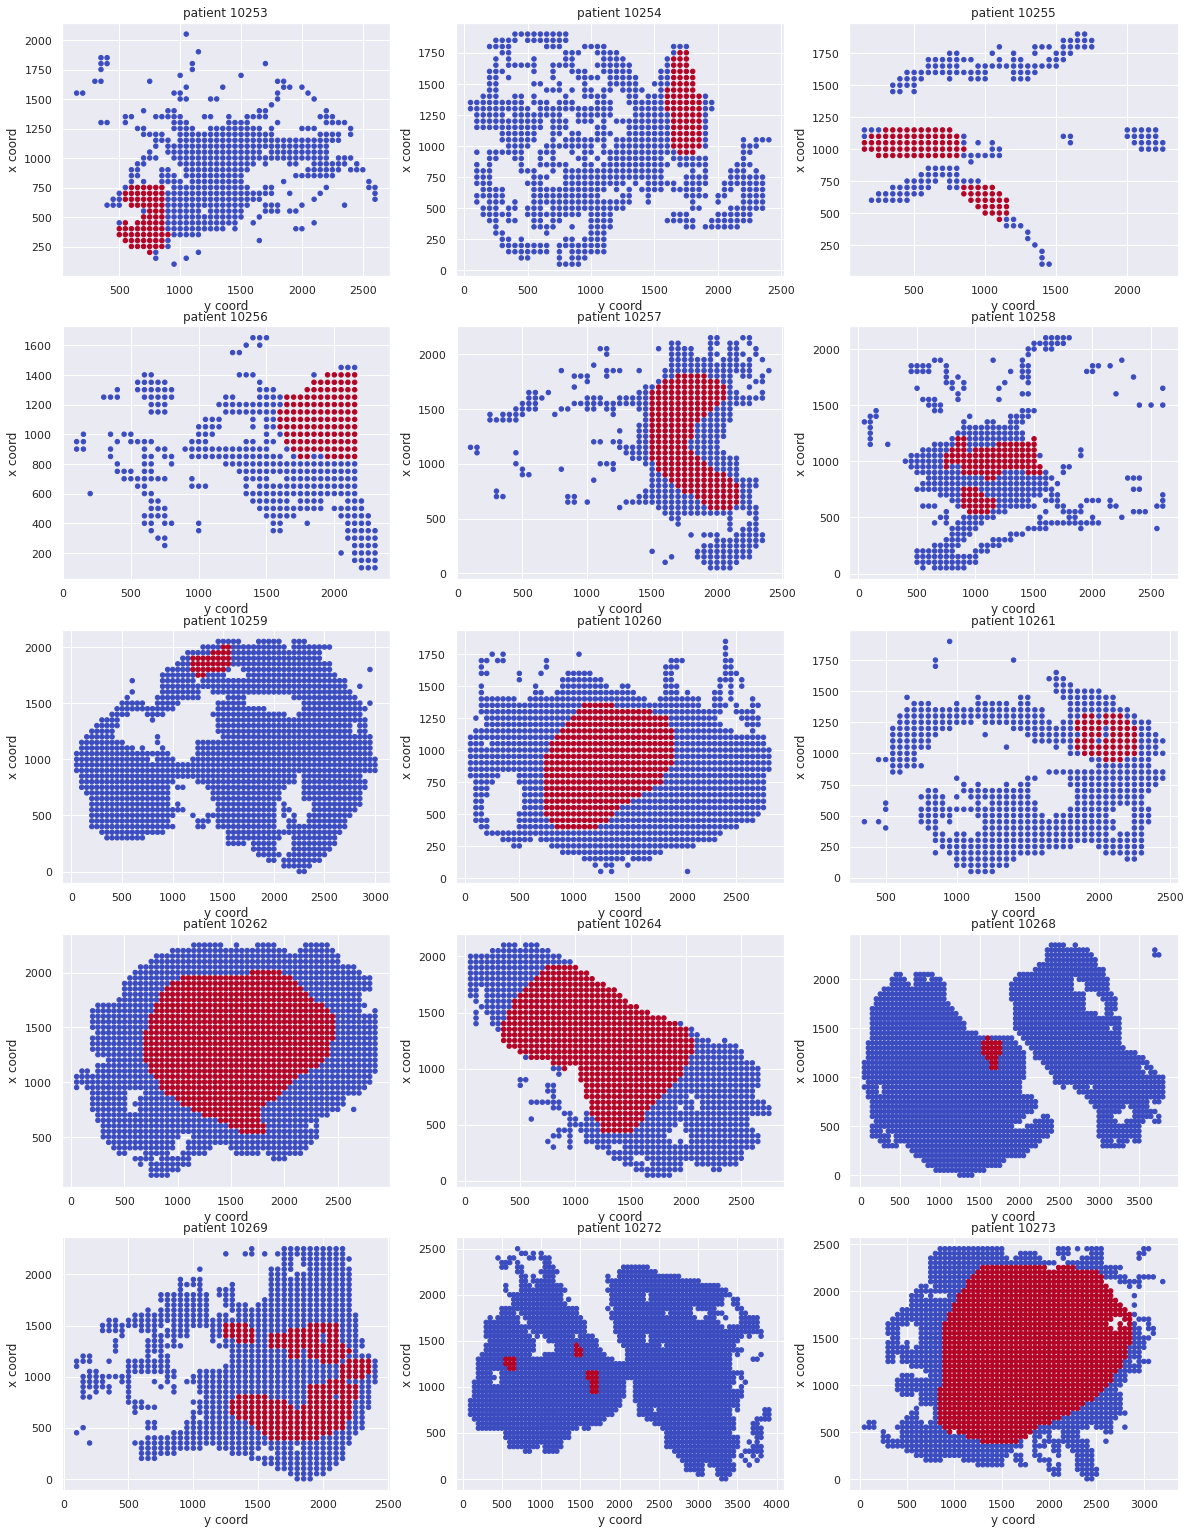

In [84]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
  for m in range(3):
    patient_id = patient_ids[m+3*n]
    example_df = get_patient_dataframe(patient_id)
    
    ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
    ax[n,m].set_title("patient " + patient_id)
    ax[n,m].set_xlabel("y coord")
    ax[n,m].set_ylabel("x coord")    

In [89]:
def visualise_breast_tissue(patient_id, pred_df=None):
  example_df = get_patient_dataframe(patient_id)
  max_point = [example_df.y.max()-1, example_df.x.max()-1]
  grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
  mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)

  if pred_df is not None:
    patient_df = pred_df[pred_df.patient_id == patient_id].copy()
  mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.float)

  broken_patches = []
  for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
  return grid, mask, broken_patches, mask_proba

In [90]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

dataframe:                               filename
0    10273_idx5_x1001_y1901_class0.png
1    10273_idx5_x1001_y1951_class0.png
2    10273_idx5_x1001_y2001_class0.png
3    10273_idx5_x1001_y2051_class0.png
4    10273_idx5_x1001_y2101_class0.png
..                                 ...
806    10273_idx5_x951_y251_class0.png
807    10273_idx5_x951_y301_class0.png
808    10273_idx5_x951_y351_class0.png
809    10273_idx5_x951_y401_class0.png
810    10273_idx5_x951_y451_class0.png

[811 rows x 1 columns]
rsplit:          0     1      2      3           4
0    10273  idx5  x1001  y1901  class0.png
1    10273  idx5  x1001  y1951  class0.png
2    10273  idx5  x1001  y2001  class0.png
3    10273  idx5  x1001  y2051  class0.png
4    10273  idx5  x1001  y2101  class0.png
..     ...   ...    ...    ...         ...
806  10273  idx5   x951   y251  class0.png
807  10273  idx5   x951   y301  class0.png
808  10273  idx5   x951   y351  class0.png
809  10273  idx5   x951   y401  class0.png
810  10273  idx5